# STOXX Europe 600 - Download and Merge Historical Data

This notebook:
1. Downloads SXXR.Z data from Yahoo Finance (1986-2015) and saves it to `data/stoxx/YAHOO_SXXR.Z_DAILY.csv`
2. Merges Yahoo Finance data with existing Investing.com data (`STOXX Europe 600 EUR NR Historical Data-2012-2025.csv`)
3. When dates overlap, keeps the data from the Investing.com file (priority)
4. Saves the merged result to `data/stoxx/STOXX_SXXGR_DAILY.csv`


In [1]:
import pandas as pd
import os
import yfinance as yf
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')


In [2]:
# Change to project root directory
# Find the project root by looking for the 'data' directory
current_dir = os.getcwd()
while not os.path.exists(os.path.join(current_dir, 'data')):
    parent_dir = os.path.dirname(current_dir)
    if parent_dir == current_dir:
        # Reached filesystem root without finding 'data' directory
        raise FileNotFoundError("Could not find project root directory (looking for 'data' folder)")
    current_dir = parent_dir

os.chdir(current_dir)
print(f"Working directory: {os.getcwd()}")

# Define file paths
yahoo_output_file = 'data/stoxx/YAHOO_SXXR.Z_DAILY.csv'
investing_file = 'data/stoxx/STOXX Europe 600 EUR NR Historical Data-2012-2025.csv'
merged_output_file = 'data/stoxx/STOXX_SXXGR_DAILY.csv'

# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(yahoo_output_file), exist_ok=True)


Working directory: /workspace


## Step 1: Download SXXR.Z from Yahoo Finance (1986-2015)


In [3]:
# Download SXXR.Z from Yahoo Finance
ticker = "SXXR.Z"
start_date = "1986-01-01"
end_date = "2015-12-31"

print(f"Downloading {ticker} from Yahoo Finance...")
print(f"Date range: {start_date} to {end_date}")

# Download the data
ticker_obj = yf.Ticker(ticker)
df_yahoo = ticker_obj.history(start=start_date, end=end_date)

print(f"\nDownloaded data shape: {df_yahoo.shape}")
print(f"Columns: {df_yahoo.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_yahoo.head(10))
print(f"\nLast few rows:")
print(df_yahoo.tail(10))


Date range: 1986-01-01 to 2015-12-31

Downloaded data shape: (7391, 7)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

First few rows:
                                Open       High        Low      Close  Volume  \
Date                                                                            
1986-12-31 00:00:00+01:00  73.559998  73.559998  73.559998  73.559998       0   
1987-01-01 00:00:00+01:00  73.559998  73.559998  73.559998  73.559998       0   
1987-01-02 00:00:00+01:00  73.400002  73.400002  73.400002  73.400002       0   
1987-01-05 00:00:00+01:00  73.620003  73.620003  73.620003  73.620003       0   
1987-01-06 00:00:00+01:00  74.029999  74.029999  74.029999  74.029999       0   
1987-01-07 00:00:00+01:00  74.470001  74.470001  74.470001  74.470001       0   
1987-01-08 00:00:00+01:00  74.239998  74.239998  74.239998  74.239998       0   
1987-01-09 00:00:00+01:00  73.800003  73.800003  73.800003  73.800003       0   
1987-01-12 00:00:00+0

In [4]:
# Prepare Yahoo data for saving
# Reset index to get Date as a column
df_yahoo_reset = df_yahoo.reset_index()

# Select Date and Close (Price) columns
# yfinance uses 'Close' as the price column
df_yahoo_clean = df_yahoo_reset[['Date', 'Close']].copy()
df_yahoo_clean.columns = ['date', 'Price']

# Convert date to string format
df_yahoo_clean['date'] = pd.to_datetime(df_yahoo_clean['date']).dt.strftime('%Y-%m-%d')

# Sort by date
df_yahoo_clean = df_yahoo_clean.sort_values(by='date').reset_index(drop=True)

print(f"Yahoo data prepared:")
print(f"  Shape: {df_yahoo_clean.shape}")
print(f"  Date range: {df_yahoo_clean['date'].min()} to {df_yahoo_clean['date'].max()}")
print(f"\nFirst few rows:")
print(df_yahoo_clean.head(10))
print(f"\nLast few rows:")
print(df_yahoo_clean.tail(10))


Yahoo data prepared:
  Shape: (7391, 2)
  Date range: 1986-12-31 to 2015-12-17

First few rows:
         date      Price
0  1986-12-31  73.559998
1  1987-01-01  73.559998
2  1987-01-02  73.400002
3  1987-01-05  73.620003
4  1987-01-06  74.029999
5  1987-01-07  74.470001
6  1987-01-08  74.239998
7  1987-01-09  73.800003
8  1987-01-12  74.349998
9  1987-01-13  73.779999

Last few rows:
            date       Price
7381  2015-12-04  713.817017
7382  2015-12-07  717.489014
7383  2015-12-08  704.533020
7384  2015-12-09  701.536987
7385  2015-12-10  699.706970
7386  2015-12-11  685.419006
7387  2015-12-14  673.367981
7388  2015-12-15  692.718018
7389  2015-12-16  694.359985
7390  2015-12-17  703.020020


In [5]:
# Save Yahoo Finance data to CSV
df_yahoo_clean.to_csv(yahoo_output_file, index=False)
print(f"Yahoo Finance data saved to: {yahoo_output_file}")
print(f"Dimensions: {len(df_yahoo_clean)} rows, {len(df_yahoo_clean.columns)} columns")


Yahoo Finance data saved to: data/stoxx/YAHOO_SXXR.Z_DAILY.csv
Dimensions: 7391 rows, 2 columns


## Step 2: Read and Prepare Investing.com Data


In [6]:
# Read the Investing.com CSV file
print(f"Reading Investing.com file: {investing_file}")

# The file has Date and Price columns
# Date format appears to be MM/DD/YYYY
# Price has commas as thousand separators
df_investing = pd.read_csv(investing_file)

print(f"\nInvesting.com data shape: {df_investing.shape}")
print(f"Columns: {df_investing.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_investing.head(10))
print(f"\nLast few rows:")
print(df_investing.tail(10))


Reading Investing.com file: data/stoxx/STOXX Europe 600 EUR NR Historical Data-2012-2025.csv

Investing.com data shape: (3324, 7)
Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First few rows:
         Date     Price      Open      High       Low  Vol. Change %
0  12/12/2025  1,446.25  1,455.64  1,462.41  1,445.77   NaN   -0.53%
1  12/11/2025  1,453.99  1,445.73  1,456.61  1,441.29   NaN    0.55%
2  12/10/2025  1,446.03  1,443.99  1,446.44  1,440.03   NaN    0.07%
3  12/09/2025  1,445.02  1,447.56  1,451.28  1,443.93   NaN   -0.10%
4  12/08/2025  1,446.48  1,445.68  1,448.63  1,444.04   NaN   -0.07%
5  12/05/2025  1,447.51  1,449.12  1,454.14  1,447.51   NaN   -0.01%
6  12/04/2025  1,447.67  1,444.68  1,449.67  1,441.72   NaN    0.46%
7  12/03/2025  1,441.03  1,440.50  1,446.18  1,437.39   NaN    0.10%
8  12/02/2025  1,439.57  1,437.96  1,444.40  1,436.49   NaN    0.08%
9  12/01/2025  1,438.44  1,438.41  1,439.87  1,432.02   NaN   -0.20%

Last few rows:
        

In [7]:
# Clean and prepare Investing.com data
# Select only Date and Price columns
df_investing_clean = df_investing[['Date', 'Price']].copy()
df_investing_clean.columns = ['date', 'Price']

# Convert date from MM/DD/YYYY to datetime, then to YYYY-MM-DD
df_investing_clean['date'] = pd.to_datetime(df_investing_clean['date'], format='%m/%d/%Y', errors='coerce')

# Remove rows with invalid dates
df_investing_clean = df_investing_clean[df_investing_clean['date'].notna()].copy()

# Clean Price column: remove commas and convert to float
df_investing_clean['Price'] = df_investing_clean['Price'].astype(str).str.replace(',', '').astype(float)

# Convert date to string format YYYY-MM-DD
df_investing_clean['date'] = df_investing_clean['date'].dt.strftime('%Y-%m-%d')

# Sort by date
df_investing_clean = df_investing_clean.sort_values(by='date').reset_index(drop=True)

print(f"Investing.com data prepared:")
print(f"  Shape: {df_investing_clean.shape}")
print(f"  Date range: {df_investing_clean['date'].min()} to {df_investing_clean['date'].max()}")
print(f"\nFirst few rows:")
print(df_investing_clean.head(10))
print(f"\nLast few rows:")
print(df_investing_clean.tail(10))


Investing.com data prepared:
  Shape: (3324, 2)
  Date range: 2012-12-28 to 2025-12-12

First few rows:
         date   Price
0  2012-12-28  495.17
1  2012-12-31  496.77
2  2013-01-02  506.83
3  2013-01-03  509.54
4  2013-01-04  511.32
5  2013-01-07  509.19
6  2013-01-08  508.52
7  2013-01-09  512.04
8  2013-01-10  510.69
9  2013-01-11  510.05

Last few rows:
            date    Price
3314  2025-12-01  1438.44
3315  2025-12-02  1439.57
3316  2025-12-03  1441.03
3317  2025-12-04  1447.67
3318  2025-12-05  1447.51
3319  2025-12-08  1446.48
3320  2025-12-09  1445.02
3321  2025-12-10  1446.03
3322  2025-12-11  1453.99
3323  2025-12-12  1446.25


## Step 3: Merge Yahoo Finance and Investing.com Data


In [8]:
# Merge the two dataframes
# Strategy: 
# 1. Start with Yahoo Finance data (1986-2015)
# 2. Add/overwrite with Investing.com data (2012-2025)
# 3. When dates overlap, keep Investing.com data (priority)
# 4. Sort by date

# Combine both dataframes
df_merged = pd.concat([df_yahoo_clean, df_investing_clean], ignore_index=True)

# Remove duplicates, keeping the last occurrence (which will be from Investing.com if both exist)
df_merged = df_merged.drop_duplicates(subset='date', keep='last')

# Sort by date
df_merged = df_merged.sort_values(by='date').reset_index(drop=True)

print(f"Merged data:")
print(f"  Shape: {df_merged.shape}")
print(f"  Date range: {df_merged['date'].min()} to {df_merged['date'].max()}")
print(f"\nFirst few rows:")
print(df_merged.head(10))
print(f"\nLast few rows:")
print(df_merged.tail(10))

# Check for overlapping dates
yahoo_dates = set(df_yahoo_clean['date'])
investing_dates = set(df_investing_clean['date'])
overlapping_dates = yahoo_dates.intersection(investing_dates)
print(f"\nOverlapping dates: {len(overlapping_dates)}")
if len(overlapping_dates) > 0:
    print(f"  Example overlapping dates: {sorted(list(overlapping_dates))[:5]}")


Merged data:
  Shape: (9991, 2)
  Date range: 1986-12-31 to 2025-12-12

First few rows:
         date      Price
0  1986-12-31  73.559998
1  1987-01-01  73.559998
2  1987-01-02  73.400002
3  1987-01-05  73.620003
4  1987-01-06  74.029999
5  1987-01-07  74.470001
6  1987-01-08  74.239998
7  1987-01-09  73.800003
8  1987-01-12  74.349998
9  1987-01-13  73.779999

Last few rows:
            date    Price
9981  2025-12-01  1438.44
9982  2025-12-02  1439.57
9983  2025-12-03  1441.03
9984  2025-12-04  1447.67
9985  2025-12-05  1447.51
9986  2025-12-08  1446.48
9987  2025-12-09  1445.02
9988  2025-12-10  1446.03
9989  2025-12-11  1453.99
9990  2025-12-12  1446.25

Overlapping dates: 724
  Example overlapping dates: ['2012-12-28', '2013-01-03', '2013-01-04', '2013-01-07', '2013-01-08']


In [9]:
# Verify that overlapping dates use Investing.com data
if len(overlapping_dates) > 0:
    print("Verifying priority (Investing.com data should be used for overlapping dates):")
    sample_overlap = sorted(list(overlapping_dates))[:3]
    for date in sample_overlap:
        yahoo_val = df_yahoo_clean[df_yahoo_clean['date'] == date]['Price'].values
        investing_val = df_investing_clean[df_investing_clean['date'] == date]['Price'].values
        merged_val = df_merged[df_merged['date'] == date]['Price'].values
        
        print(f"\n  Date: {date}")
        if len(yahoo_val) > 0:
            print(f"    Yahoo Finance: {yahoo_val[0]}")
        if len(investing_val) > 0:
            print(f"    Investing.com: {investing_val[0]}")
        if len(merged_val) > 0:
            print(f"    Merged (used): {merged_val[0]}")
            if len(investing_val) > 0:
                print(f"    ✓ Matches Investing.com: {merged_val[0] == investing_val[0]}")


Verifying priority (Investing.com data should be used for overlapping dates):

  Date: 2012-12-28
    Yahoo Finance: 495.1719970703125
    Investing.com: 495.17
    Merged (used): 495.17
    ✓ Matches Investing.com: True

  Date: 2013-01-03
    Yahoo Finance: 509.5450134277344
    Investing.com: 509.54
    Merged (used): 509.54
    ✓ Matches Investing.com: True

  Date: 2013-01-04
    Yahoo Finance: 511.31500244140625
    Investing.com: 511.32
    Merged (used): 511.32
    ✓ Matches Investing.com: True


## Step 4: Visualize Merged Data


Plot saved to: data/stoxx/STOXX_SXXGR_DAILY_plot.png


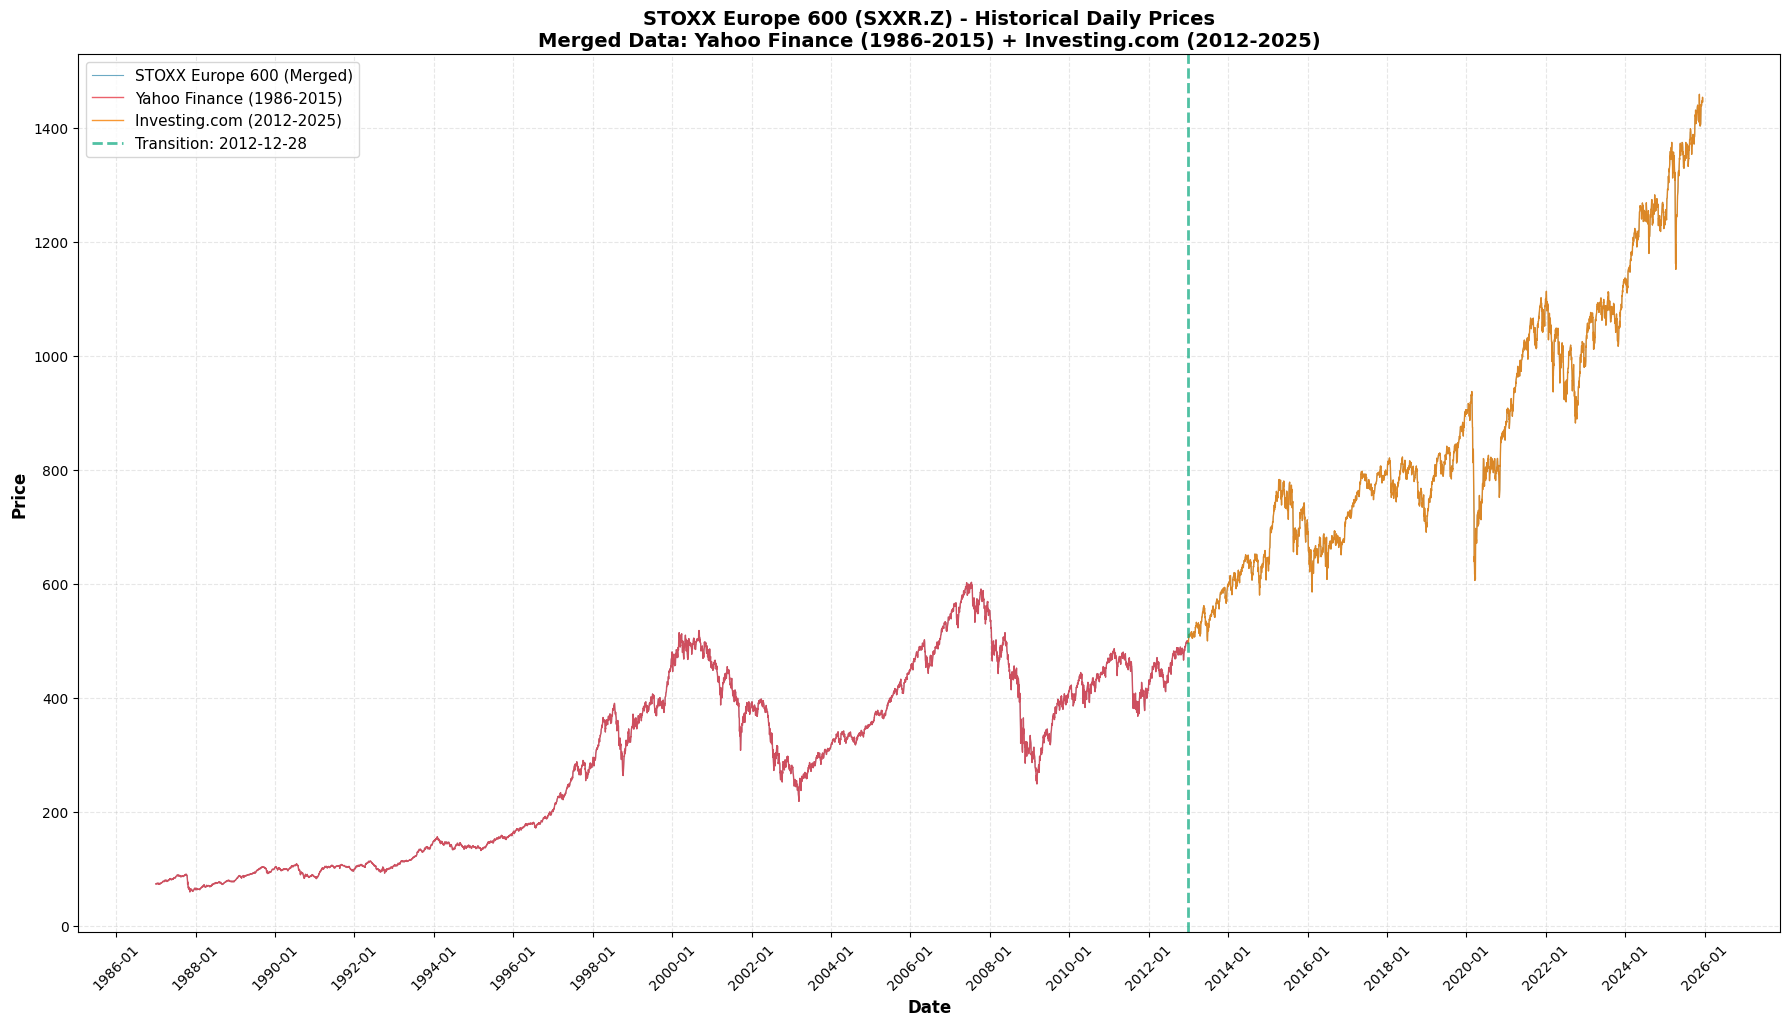

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert date column to datetime for plotting
df_plot = df_merged.copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])

# Identify the transition point (where Investing.com data starts)
transition_date = pd.to_datetime(df_investing_clean['date'].min())

# Create the plot
plt.figure(figsize=(18, 10))

# Plot the entire merged series
plt.plot(df_plot['date'], df_plot['Price'], 
         linewidth=0.8, color='#2E86AB', alpha=0.7,
         label='STOXX Europe 600 (Merged)')

# Highlight the Yahoo Finance period (before transition)
yahoo_period = df_plot[df_plot['date'] < transition_date].copy()
if len(yahoo_period) > 0:
    plt.plot(yahoo_period['date'], yahoo_period['Price'], 
            linewidth=1, color='#E63946', alpha=0.8,
            label='Yahoo Finance (1986-2015)')

# Highlight the Investing.com period (from transition onwards)
investing_period = df_plot[df_plot['date'] >= transition_date].copy()
if len(investing_period) > 0:
    plt.plot(investing_period['date'], investing_period['Price'], 
            linewidth=1, color='#F77F00', alpha=0.8,
            label='Investing.com (2012-2025)')

# Add vertical line to show transition point
plt.axvline(x=transition_date, color='#06A77D', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Transition: {transition_date.strftime("%Y-%m-%d")}')

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.title('STOXX Europe 600 (SXXR.Z) - Historical Daily Prices\nMerged Data: Yahoo Finance (1986-2015) + Investing.com (2012-2025)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='best', fontsize=11)
plt.tight_layout()

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every 2 years
plt.xticks(rotation=45)

# Save plot
plot_file = os.path.join(os.path.dirname(merged_output_file), 'STOXX_SXXGR_DAILY_plot.png')
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"Plot saved to: {plot_file}")

plt.show()


In [11]:
# Save merged data to CSV
df_merged.to_csv(merged_output_file, index=False)
print(f"Merged data saved to: {merged_output_file}")
print(f"Dimensions: {len(df_merged)} rows, {len(df_merged.columns)} columns")
print(f"\nSummary statistics:")
print(df_merged['Price'].describe())


Merged data saved to: data/stoxx/STOXX_SXXGR_DAILY.csv
Dimensions: 9991 rows, 2 columns

Summary statistics:
count    9991.000000
mean      481.828608
std       332.442253
min        59.490002
25%       179.595001
50%       420.850006
75%       693.680000
max      1459.230000
Name: Price, dtype: float64
